In [4]:
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from funcs.logic import langchain_process_pdfs_to_faiss_with_positions
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph
from funcs.logic import get_qa_score
from langchain_huggingface import HuggingFaceEmbeddings
source_dir = "data/source/pdf"
output_dir = "data/vectordb/pdf_langchain"
embedding_model = "intfloat/multilingual-e5-small"
# embedding_model = "intfloat/multilingual-e5-large-instruct"


In [2]:
vectordb = langchain_process_pdfs_to_faiss_with_positions(source_dir, output_dir,
                                         embedding_model_name=embedding_model,
                                         chunk_size=500, chunk_overlap=50)



📄 처리 중: 카카오계정약관20240416.pdf
📄 처리 중: 카카오 서비스 약관20230109.pdf
📄 처리 중: Daum서비스약관20211207.pdf
✅ 총 118개 청크 생성
✅ 저장 완료: data/vectordb/pdf_langchain


In [5]:
# 1️⃣ FAISS 벡터 DB 로드
qa_tokenizer = AutoTokenizer.from_pretrained("Dongjin-kr/ko-reranker")
qa_model = AutoModelForSequenceClassification.from_pretrained("Dongjin-kr/ko-reranker")

vector_db = FAISS.load_local(
    output_dir,
    HuggingFaceEmbeddings(model_name=embedding_model),
    allow_dangerous_deserialization=True  # 보안 옵션 추가
)

In [6]:
# LangGraph pipeline 실행
class QAState(TypedDict):
    question: str
    retrieved_docs: Optional[List]
    reranked_docs: Optional[List]
    top_docs: Optional[List]
    answer: Optional[str]


def retrieve_documents(state: QAState):
    question = state["question"]
    retrieved_docs = vector_db.similarity_search_with_score(question, k=30)
    return {"retrieved_docs": retrieved_docs}


def rerank_documents(state: QAState):
    question = state["question"]
    retrieved_docs = state["retrieved_docs"]

    scored_docs = []
    _score = []
    for doc, _ in retrieved_docs:
        score = get_qa_score(question, doc.page_content, qa_tokenizer, qa_model)
        scored_docs.append((doc, score))
        _score.append(score)

    _average = sum(_score) / len(_score)

    reranked_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)
    # top_docs = [doc for doc, _ in reranked_docs[:10]]
    top_docs = []
    for doc, score in reranked_docs[:10]:
        doc.metadata["score"] = score
        if score > _average:
            top_docs.append(doc)

    return {
        "reranked_docs": reranked_docs,
        "top_docs": top_docs,
    }





In [7]:
graph = StateGraph(QAState)

graph.add_node("retrieve_documents", retrieve_documents)
graph.add_node("rerank_documents", rerank_documents)

graph.set_entry_point("retrieve_documents")
graph.add_edge("retrieve_documents", "rerank_documents")


graph.set_finish_point("retrieve_documents")

qa_graph = graph.compile()


In [9]:
result = qa_graph.invoke({"question": f"이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니까?"})

In [10]:
result['top_docs']

[Document(id='a394e59d-d256-4830-b62b-b6eb364c32be', metadata={'producer': 'macOS 버전 12.6(빌드 21G115) Quartz PDFContext', 'creator': '', 'creationdate': "D:20240401062205Z00'00'", 'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'file_path': 'data/source/pdf/카카오계정약관20240416.pdf', 'total_pages': 17, 'format': 'PDF 1.3', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20240401062205Z00'00'", 'trapped': '', 'modDate': "D:20240401062205Z00'00'", 'creationDate': "D:20240401062205Z00'00'", 'page': 13, 'score': 0.9999274015426636}, page_content='하여 중단하거나, 재가입에 제한을 둘 수도 있습니다. 또한 여러분이 서비스와 관련된 설비의 오작동이나 시스템의 파괴 및 혼란을 유발하는 등 서비스 제공에 악영향을 미치거나 안정적 운영을 심각하게 방해한 경우, 회사는 이러한 위험 활동이 확인된 여러분의 계정들에 대하여 이용제한을 할 수 있습니다. 다만, 여러분은 이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니다. ④ 본 조에서 정한 사항 및 그 밖에 카카오계정 서비스의 이용에 관한 자세한 사항은 카카오 운영정책 등을 참고해 주시기 바랍니다.  제 13 조 (개인정보의 보호)  여러분의 개인정보의 안전한 처리는 회사에게 있어 가장 중요한 일 중 하나입니다. 여러분의 개인정보는 서비스의 원활한 제공을 위하여 여러분이 동의한 목적과 범위 내에

In [8]:
import csv

# CSV 파일을 읽어 딕셔너리 리스트로 저장
data_list = []
with open("data/checklist.csv", newline='', encoding="utf-8-sig") as csvfile:
    reader = csv.DictReader(csvfile)  # 각 행을 딕셔너리로 변환
    for row in reader:
        op = {
            'code':row['code'],
            'item':row['item'],
            'exp' : row['exp'],
              }
        result = qa_graph.invoke({"question": f"{row['item']}"})

        op['result'] = result
        data_list.append(op)

/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPy

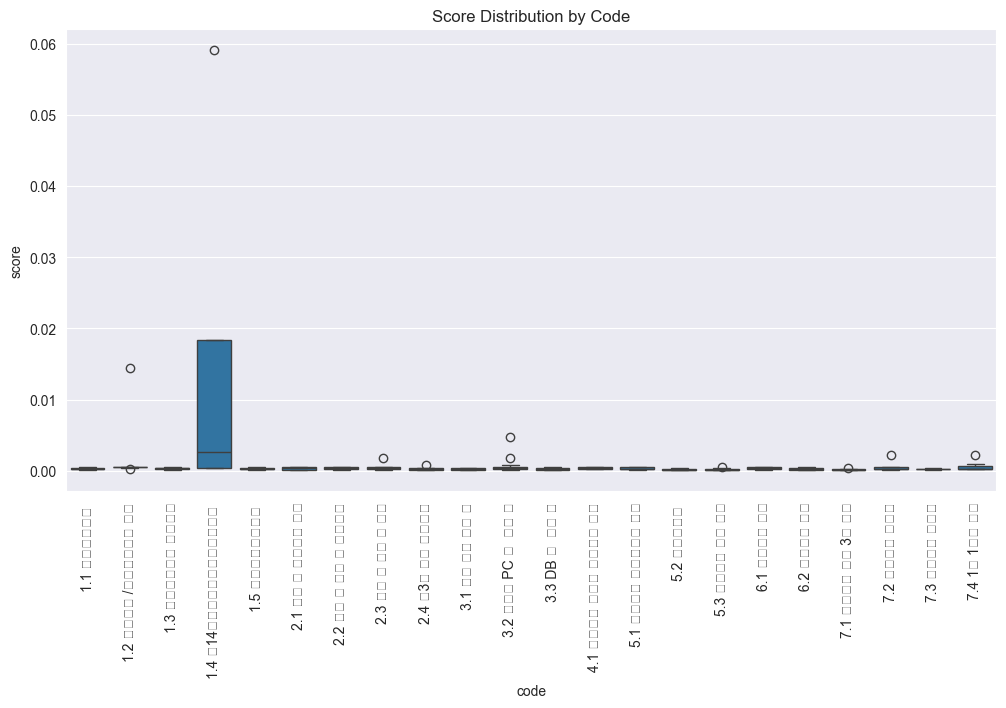

In [9]:
import pandas as pd


result_list = []
for _documents in data_list:
    for _docs in _documents['result']['top_docs']:
        _dummy = {
            "code":_documents['code'],
            "item":_documents['item'],
            "page_content": _docs.page_content,
            "score": _docs.metadata['score'],
        }
        result_list.append(_dummy)


df = pd.DataFrame(result_list)



mean_scores = df.groupby('code')['score'].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt




# 박스 플롯 그리기
plt.figure(figsize=(12, 6))
sns.boxplot(x='code', y='score', data=df)
plt.xticks(rotation=90)
plt.title('Score Distribution by Code')
plt.show()

In [11]:
result['top_docs']

[Document(id='f3c69cec-ea36-4168-b9bc-cc8acd954783', metadata={'producer': 'macOS 버전 12.6(빌드 21G115) Quartz PDFContext', 'creator': '', 'creationdate': "D:20240401062205Z00'00'", 'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'file_path': 'data/source/pdf/카카오계정약관20240416.pdf', 'total_pages': 17, 'format': 'PDF 1.3', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20240401062205Z00'00'", 'trapped': '', 'modDate': "D:20240401062205Z00'00'", 'creationDate': "D:20240401062205Z00'00'", 'page': 13, 'score': 0.999916672706604}, page_content='하여 중단하거나, 재가입에 제한을 둘 수도 있습니다. 또한 여러분이 서비스와 관련된 설\n비의 오작동이나 시스템의 파괴 및 혼란을 유발하는 등 서비스 제공에 악영향을 미치거\n나 안정적 운영을 심각하게 방해한 경우, 회사는 이러한 위험 활동이 확인된 여러분의 \n계정들에 대하여 이용제한을 할 수 있습니다. 다만, 여러분은 이용제한과 관련하여 조치 \n결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니다. \n④ 본 조에서 정한 사항 및 그 밖에 카카오계정 서비스의 이용에 관한 자세한 사항은 카카\n오 운영정책 등을 참고해 주시기 바랍니다. \n \n제 13 조 (개인정보의 보호) \n \n여러분의 개인정보의 안전한 처리는 회사에게 있어 가장 중요한 일 중 하나입니다. 여러분\n의 개인정보는 서비스의 원활한 제공을 위